# Imports

In [17]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split

# Dataset preperation

Preparing the sample dataset directory

In [18]:
# I used a dataset from kaggle.




# DATASET PROBLEMS:
# Cats have generally more prominent and clear features than dogs.
# Their ears, eyes and noses are very distinct and clear in images.
# The problem is that the dataset itself does not contain a lot of clear images of dogs.
# So a lot of cat images are blurred and unclear so we can't really see those features of cats.
# Hence, the model might be predicting a lot of cats as dogs.

In [19]:
# Remove the sampled_dataset directory.
shutil.rmtree('sampled_dataset', ignore_errors=True)

In [20]:
# Dataset directories.
TRAIN_DIR_DOGS = './archive/dataset/training_set/dogs/'
TRAIN_DIR_CATS = './archive/dataset/training_set/cats/'
TEST_DIR_DOGS = './archive/dataset/test_set/dogs/'
TEST_DIR_CATS = './archive/dataset/test_set/cats/'

In [21]:
# Function to load and sample dataset paths.
def load_and_sample_dataset_paths(train_sample_size, test_sample_size):
    # Crate a list of paths to all images in the dataset.
    train_images_dogs = [TRAIN_DIR_DOGS + i for i in os.listdir(TRAIN_DIR_DOGS)]
    train_images_cats = [TRAIN_DIR_CATS + i for i in os.listdir(TRAIN_DIR_CATS)]
    test_images_dogs = [TEST_DIR_DOGS + i for i in os.listdir(TEST_DIR_DOGS)]
    test_images_cats = [TEST_DIR_CATS + i for i in os.listdir(TEST_DIR_CATS)]
    
    # Now take samples from the list of paths.
    train_images_dogs_sample = random.sample(train_images_dogs, train_sample_size)
    train_images_cats_sample = random.sample(train_images_cats, train_sample_size)
    test_images_dogs_sample = random.sample(test_images_dogs, test_sample_size)
    test_images_cats_sample = random.sample(test_images_cats, test_sample_size)


    print('Train Dogs:', len(train_images_dogs_sample))
    print('Train Cats:', len(train_images_cats_sample))
    print('Test Dogs:', len(test_images_dogs_sample))
    print('Test Cats:', len(test_images_cats_sample))

    return train_images_dogs_sample, train_images_cats_sample, test_images_dogs_sample, test_images_cats_sample

In [22]:
# Set sample size.
train_sample_size = 700
test_sample_size = 100

train_images_dogs, train_images_cats, test_images_dogs, test_images_cats = load_and_sample_dataset_paths(train_sample_size, test_sample_size)

Train Dogs: 700
Train Cats: 700
Test Dogs: 100
Test Cats: 100


In [23]:
# Create a function to create the new directory structure for the sampled dataset.
def create_sampled_directory_structure(train_images_dogs, train_images_cats, test_images_dogs, test_images_cats, base_dir='./sampled_dataset/'):
    # Create 3 sub-directories inside the sampled_dataset structure.
    train_dir = os.path.join(base_dir, 'training_set')
    val_dir = os.path.join(base_dir, 'validation_set')
    test_dir = os.path.join(base_dir, 'test_set')
    
    # Add the sub-directories, dogs and cats, to each of the .
    train_dogs_dir = os.path.join(train_dir, 'dogs')
    train_cats_dir = os.path.join(train_dir, 'cats')
    val_dogs_dir = os.path.join(val_dir, 'dogs')
    val_cats_dir = os.path.join(val_dir, 'cats')
    test_dogs_dir = os.path.join(test_dir, 'dogs')
    test_cats_dir = os.path.join(test_dir, 'cats')
    

    # Here we create the actual directories.
    os.makedirs(train_dogs_dir, exist_ok=True)
    os.makedirs(train_cats_dir, exist_ok=True)
    os.makedirs(val_dogs_dir, exist_ok=True)
    os.makedirs(val_cats_dir, exist_ok=True)
    os.makedirs(test_dogs_dir, exist_ok=True)
    os.makedirs(test_cats_dir, exist_ok=True)
    
    # Split the train_images_dogs into training and validation sets.
    train_images_dogs, val_images_dogs = train_test_split(train_images_dogs, test_size=0.3, random_state=42)
    train_images_cats, val_images_cats = train_test_split(train_images_cats, test_size=0.3, random_state=42)
    
    # Now copy the the actual image paths to he new directories.
    for img_path in train_images_dogs:
        shutil.copy(img_path, os.path.join(train_dogs_dir, os.path.basename(img_path)))
    for img_path in train_images_cats:
        shutil.copy(img_path, os.path.join(train_cats_dir, os.path.basename(img_path)))
    for img_path in val_images_dogs:
        shutil.copy(img_path, os.path.join(val_dogs_dir, os.path.basename(img_path)))
    for img_path in val_images_cats:
        shutil.copy(img_path, os.path.join(val_cats_dir, os.path.basename(img_path)))
    for img_path in test_images_dogs:
        shutil.copy(img_path, os.path.join(test_dogs_dir, os.path.basename(img_path)))
    for img_path in test_images_cats:
        shutil.copy(img_path, os.path.join(test_cats_dir, os.path.basename(img_path)))

    print('Train Dogs:', len(os.listdir(train_dogs_dir)))
    print('Train Cats:', len(os.listdir(train_cats_dir)))
    print('Validation Dogs:', len(os.listdir(val_dogs_dir)))
    print('Validation Cats:', len(os.listdir(val_cats_dir)))
    print('Test Dogs:', len(os.listdir(test_dogs_dir)))
    print('Test Cats:', len(os.listdir(test_cats_dir)))
    
    return train_dir, val_dir, test_dir

In [24]:
# Create sampled directory structure (call the function)
sampled_train_data_dir, sampled_val_data_dir, sampled_test_data_dir = create_sampled_directory_structure(train_images_dogs, train_images_cats, test_images_dogs, test_images_cats)

Train Dogs: 490
Train Cats: 490
Validation Dogs: 210
Validation Cats: 210
Test Dogs: 100
Test Cats: 100


# Data Preprocessing

In [25]:
# Preprocessing techniques:
# - Resizing: Images are resized to 128x128 pixels for consistency in model input size.
# - Normalization: Pixel values are rescaled to a range of [0, 1].
# - Augmentation: Data augmentation is applied to the training set,
#                 including zooming and horizontal flipping, to increase the diversity of training examples.

# BATCH SIZE:
# i chose the batch size as 32, because smaller batch sizes can provide more noise,
# and hence the model can generalize better.
# But they tend to make the models training phase slower too.
# So it's of course a trade-off

In [26]:
# Bias prevention:
# - To prevent bias, augmentation techniques are applied consistently to all classes to ensure that the model
#                 learns general features of cats and dogs rather than specific artifacts present in the training images.

In [27]:
# Data Augmentation.
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalization (scaling pixel values)
    zoom_range=0.2,             # Zoom in by 20%
    horizontal_flip=True,       # Flip horizontally
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# The flow_from_directory function loads the images from the directory and applies the augmentation methods on them.

# IMPORTANT NOTE:
# Image Class labeling is done implicitly by the sub-directory names in the directory structure.
# The sub-directory names are the class labels.
# This is done by the flow_from_directory function.

In [28]:
train_generator = train_datagen.flow_from_directory(
    sampled_train_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    sampled_val_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    sampled_test_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 980 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Model Implementation

In [29]:
# Architecture Design:
# I initially wanted to create a very fast and efficient model that could be trained quickly.
# I decided to use a simple Convolutional Neural Network (CNN) architecture with 3 convolutional layers,
# 3 max-pooling layers, and 2 fully connected layers. The model uses the ReLU activation function
# for the convolutional layers and the softmax activation function for the output layer.
# A Dropout layer is added to prevent overfitting.

# FILTER SIZES:
# I used a 3 by 3 filter size because its the smallest filter size possible that can still capture
# spatial features effectively, like corners and edges and so on. (its also the most common filter size used in CNN)
# I used a 2 by 2 pooling filter because a too large one will lead to too much dataloss.
#  (its also the most common filter size used in CNN)


# PARAMETERS:
# Other parameters like the Dropout and the learning rate, are simply tuning parameters.
# They should be selected and modified based on the performance of the model.

# ACTIVATION FUNCTION:
# We used the relu activation function because it is the most common activation function used in CNNs.
# It also avoids the vanishing gradient problem in backprpagation.

# STRIDE:
# the default stride value of 2 is used.
# It's also the most common stride value used in CNNs.
# => Not too much dataloss, while still skipping a row for more computational efficiency.

# FULLY CONNECTED LAYER:
# We have 2 fully connected layers.
# One is 64 neurons, for speed and efficiency.
# The other is 2 because we have 2 output classes

# OPTIMIZER:
# Adam optimizer because its the most commonly used nowadays.
# It's popular for its adaptive learning rate and momentum. => faster convergence.

# No regularization technique was used.

# 30 epochs were chosen because the model is designed for speed and efficiency.
# So i want small complexity and high speed.

# I also didnt use early stopping because the number of epochs is small.
# I did use it tho in other archtiectur experiments. In this specific case, it was not necessary.

In [30]:
# Different Architecture Experimentation:
# I did experiment with a bunch of different architectures.
# I used a larger CNN model with more layers, one that takes in a smaller input size.
# I even used predefined models like VGG16, which did show the best performance during training and validation.

In [31]:
# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30
)

# steps_per_epoch:  Number of batches the model processes in one epoch.
# validation_steps: Number of batches the model processes in one validation epoch.

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.4881 - loss: 0.7063 - val_accuracy: 0.4952 - val_loss: 0.6921
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.4062 - loss: 0.6965 - val_accuracy: 1.0000 - val_loss: 0.6856
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.5368 - loss: 0.6921 - val_accuracy: 0.5216 - val_loss: 0.6845
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.6562 - loss: 0.6646 - val_accuracy: 0.7500 - val_loss: 0.6213
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.5255 - loss: 0.6867 - val_accuracy: 0.5216 - val_loss: 0.6895
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.5000 - loss: 0.6918 - val_accuracy: 0.2500 - val_loss: 0.6988
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.5585 - loss: 0.6894 - val_accuracy: 0.6034 - val_loss: 0.6741
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.6562 - loss: 0.6376 - val_accuracy: 0

# Model Evaluation

In [33]:
# Evaluating the model on the test set.
test_metrics = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, return_dict=True)

# Extracting accuracy and loss.
test_loss = test_metrics['loss']
test_accuracy = test_metrics['accuracy']

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6875 - loss: 0.8131

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.6551 - loss: 0.7409
Test loss: 0.6891157627105713
Test accuracy: 66.67%


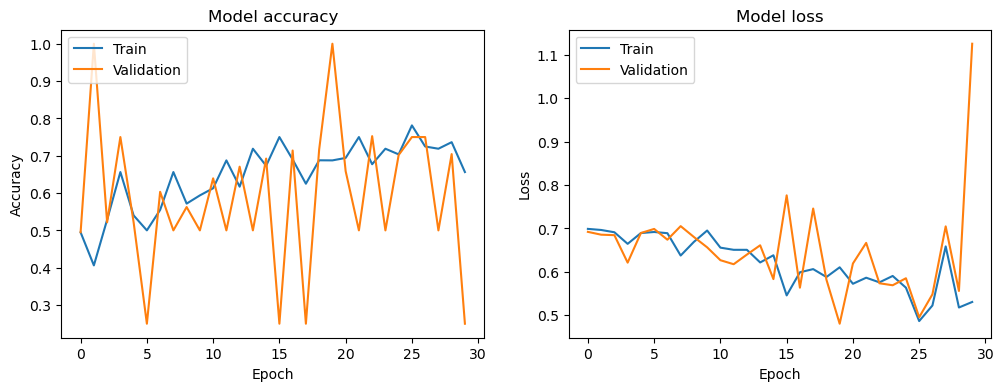

In [34]:
# Plotting training history.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Evaluation on test set.

predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Calculate accuracy.
accuracy_test = accuracy_score(y_true, y_pred)
print("Test accuracy:", accuracy_test)
# Calculate recall.
recall_test = recall_score(y_true, y_pred)
print("Test recall:", recall_test)
# Calculate precision.
precision_test = precision_score(y_true, y_pred)
print("Test precision:", precision_test)
# Calculate F1 score.
f1_test = f1_score(y_true, y_pred)
print("Test F1:", f1_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


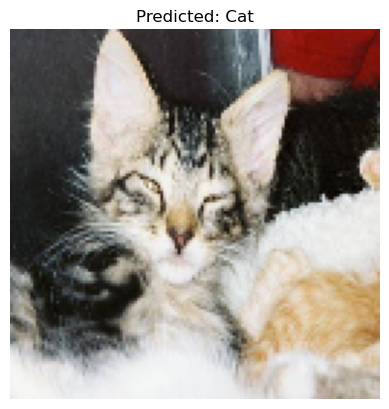

Predicted label: Cat


In [39]:
# Test prediction on a single image
def predict_single_image(image_path, model, target_size=(128, 128)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    # Add an extra dimension to the image array to match the input shape of the model.
    # Because the model takes in batches.
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    # Find the class with the highest probability.
    # argmax simply returns the index of the max value (max prediction).
    predicted_class = np.argmax(predictions)
    
    if predicted_class == 0:
        label = 'Cat'
    else:
        label = 'Dog'
    
    plt.imshow(img)
    plt.title(f'Predicted: {label}')
    plt.axis('off')
    plt.show()
    return label

# Test prediction on a single image
test_image_path = test_images_cats[13]
predicted_label = predict_single_image(test_image_path, model)
print(f"Predicted label: {predicted_label}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Accuracy: 49.50%

Class: cats
Recall: 31.00%
F1 Score: 38.04%
Precision: 49.21%

Class: dogs
Recall: 68.00%
F1 Score: 57.38%
Precision: 49.64%


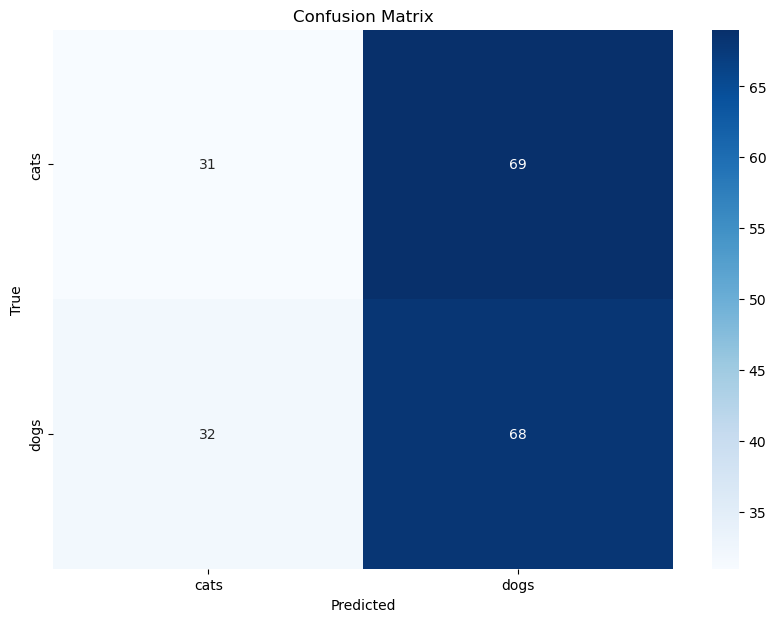

In [41]:
# Generating confusion matrix and classification report
def generate_classification_report(test_generator, model):
    # The generator has an internal counter that is incremented every time a batch is drawn.
    # We need to reset it before we start extracting the predictions, so that it starts from the beginning.
    test_generator.reset()
    # Adding +1 to the batch size because the generator returns one less batch than the actual number of batches.
    # Without it, there might be an error because it is not divisible by the batch size.
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    class_names = list(test_generator.class_indices.keys())
    metrics = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    for class_name, values in metrics.items():
        if class_name in class_names:
            print(f"\nClass: {class_name}")
            print(f"Recall: {values['recall'] * 100:.2f}%")
            print(f"F1 Score: {values['f1-score'] * 100:.2f}%")
            print(f"Precision: {values['precision'] * 100:.2f}%")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

# Generating classification metrics
classification_metrics = generate_classification_report(test_generator, model)

In [ ]:
# Printing final training and validation accuracies
train_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", validation_accuracy)

Training Accuracy: 0.65625
Validation Accuracy: 0.25


# Comparison And Analysis

Performance Comparison between the 2 models

In [ ]:
# In our comparison between a machine learning model using a bag-of-words representation
# and a Convolutional Neural Network (CNN), distinct performance trends emerged.
# The CNN model showed superior recall for dogs (68%), indicating its strength in predicting this class.
# However, it struggled with cat predictions, evidenced by its lower recall (31%). Conversely,
# the machine learning model excelled in predicting cats, boasting a higher number of
# true positives (78) for this class. However, its performance in predicting dogs was
# comparatively weaker, with fewer true positives (38). Notably, the CNN model suffered
# from overfitting, as evidenced by its high training accuracy (65.625%) and low validation accuracy (25%).
# In summary, while the CNN model demonstrated better dog predictions,
# the machine learning model was more effective in predicting cats.

Strengths and weaknesses of the model

In [ ]:
# This model fails at predicting cats. It predicts cats as dogs a lot of the time.
# This is because the dataset has a lot of unclear and blurry images of cats.
# Cats have a lot of prominent and clear features, like their sharp ears and nose and eyes.
# So, the dataset having bad images of cats leads to the model not being able to learn the features of cats properly.

# But the model did predict dogs as dogs successfully.

Identify scenarios where the hybrid approach may be more suitable than using deep learning alone

In [ ]:
# DEFINITION:
# In the context of object classification using machine learning and deep learning,
# the hybrid approach involves using both traditional machine learning techniques,
# like bag-of-words with Support Vector Classifier (SVC),
# and deep learning with Convolutional Neural Networks (CNN) to develop a classification model.


# This hybrid approach might be suitable for situations where there is a lack of labeled data.
# In this case, we do have labeled data, so bag of words might not be necessary.
# Furthermore, SVC is known for generalizing data very well, so it might be a good approach to use here,
# along with the CNN model that we already have.